In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

### Data Preparation

In [2]:
df1 = pd.read_csv('datatraining.txt', header=0, parse_dates=[0], index_col=0, squeeze=True)
df2= pd.read_csv('datatest.txt', header=0, parse_dates=[0], index_col=0, squeeze=True)
df3= pd.read_csv('datatest2.txt', header=0, parse_dates=[0], index_col=0, squeeze=True)

df4= pd.merge(df2, df1, how='outer')
df_m=pd.merge(df4, df3, how='outer')

df = df_m.set_index(['date'])


In [3]:
from data_preparation import prepare_dataset

In [4]:
class_name = 'Occupancy'
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


In [56]:
X = np.zeros(shape=(30,200))

for i in range(30):
    X[i] = np.array(df['CO2'].sample(n=200))
X.shape

(30, 200)

In [57]:
#best clustering methods
from tslearn.clustering import TimeSeriesKMeans

km_d1 = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5, random_state=0)
km_d1.fit(X)

y = km_d1.labels_

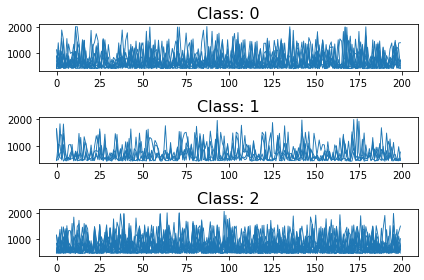

In [58]:
plt.figure()
for i, classe in enumerate([0,1,2]):
    plt.subplot(3, 1, i + 1)
    for x in X[y == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)

plt.tight_layout()

plt.show()

### Data partitioning

In [59]:
from sklearn.model_selection import train_test_split, cross_val_score ,cross_val_predict

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

# Shapelets Discovery

In [61]:
from keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

from tslearn.preprocessing import TimeSeriesScalerMinMax

In [62]:
n_ts, ts_sz = X_train.shape
n_classes = len(set(y))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 21
ts_sz 200
n_classes 3
shapelet_sizes {20: 3}


In [63]:
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=200,
                        verbose=1)

In [64]:
shp_clf.fit(X_train, y_train)

Epoch 1/200
21/21 [==============================] - 0s 12ms/step - loss: 31330.2930 - categorical_accuracy: 0.3810 - categorical_crossentropy: 31330.2676
Epoch 2/200
21/21 [==============================] - 0s 212us/step - loss: 14317277.0000 - categorical_accuracy: 0.4762 - categorical_crossentropy: 14315352.0000
Epoch 3/200
21/21 [==============================] - 0s 190us/step - loss: 10298248.0000 - categorical_accuracy: 0.1429 - categorical_crossentropy: 10297800.0000
Epoch 4/200
21/21 [==============================] - 0s 143us/step - loss: 6017173.0000 - categorical_accuracy: 0.4762 - categorical_crossentropy: 6015965.5000
Epoch 5/200
21/21 [==============================] - 0s 286us/step - loss: 9079661.0000 - categorical_accuracy: 0.3810 - categorical_crossentropy: 9078670.0000
Epoch 6/200
21/21 [==============================] - 0s 191us/step - loss: 5852449.0000 - categorical_accuracy: 0.4762 - categorical_crossentropy: 5851898.0000
Epoch 7/200
21/21 [======================

Epoch 53/200
21/21 [==============================] - 0s 333us/step - loss: 263612.3750 - categorical_accuracy: 0.8095 - categorical_crossentropy: 260684.0469
Epoch 54/200
21/21 [==============================] - 0s 191us/step - loss: 163341.4219 - categorical_accuracy: 0.7619 - categorical_crossentropy: 160386.3750
Epoch 55/200
21/21 [==============================] - 0s 191us/step - loss: 427985.9375 - categorical_accuracy: 0.8571 - categorical_crossentropy: 424936.6562
Epoch 56/200
21/21 [==============================] - 0s 143us/step - loss: 69774.0234 - categorical_accuracy: 0.8571 - categorical_crossentropy: 66779.1094
Epoch 57/200
21/21 [==============================] - 0s 191us/step - loss: 495383.4375 - categorical_accuracy: 0.6190 - categorical_crossentropy: 492361.2500
Epoch 58/200
21/21 [==============================] - 0s 190us/step - loss: 836511.2500 - categorical_accuracy: 0.8095 - categorical_crossentropy: 833231.2500
Epoch 59/200
21/21 [============================

Epoch 105/200
21/21 [==============================] - 0s 191us/step - loss: 4294.9756 - categorical_accuracy: 1.0000 - categorical_crossentropy: 0.0000e+00
Epoch 106/200
21/21 [==============================] - 0s 190us/step - loss: 4293.2583 - categorical_accuracy: 1.0000 - categorical_crossentropy: 0.0000e+00
Epoch 107/200
21/21 [==============================] - 0s 190us/step - loss: 4291.5410 - categorical_accuracy: 1.0000 - categorical_crossentropy: 0.0000e+00
Epoch 108/200
21/21 [==============================] - 0s 191us/step - loss: 4289.8247 - categorical_accuracy: 1.0000 - categorical_crossentropy: 0.0000e+00
Epoch 109/200
21/21 [==============================] - 0s 238us/step - loss: 4288.1094 - categorical_accuracy: 1.0000 - categorical_crossentropy: 0.0000e+00
Epoch 110/200
21/21 [==============================] - 0s 191us/step - loss: 4286.3936 - categorical_accuracy: 1.0000 - categorical_crossentropy: 0.0000e+00
Epoch 111/200
21/21 [==============================] - 0s 

Epoch 158/200
21/21 [==============================] - 0s 143us/step - loss: 4204.8716 - categorical_accuracy: 1.0000 - categorical_crossentropy: 0.0000e+00
Epoch 159/200
21/21 [==============================] - 0s 239us/step - loss: 4203.1899 - categorical_accuracy: 1.0000 - categorical_crossentropy: 0.0000e+00
Epoch 160/200
21/21 [==============================] - 0s 191us/step - loss: 4201.5088 - categorical_accuracy: 1.0000 - categorical_crossentropy: 0.0000e+00
Epoch 161/200
21/21 [==============================] - 0s 191us/step - loss: 4199.8286 - categorical_accuracy: 1.0000 - categorical_crossentropy: 0.0000e+00
Epoch 162/200
21/21 [==============================] - 0s 238us/step - loss: 4198.1489 - categorical_accuracy: 1.0000 - categorical_crossentropy: 0.0000e+00
Epoch 163/200
21/21 [==============================] - 0s 286us/step - loss: 4196.4697 - categorical_accuracy: 1.0000 - categorical_crossentropy: 0.0000e+00
Epoch 164/200
21/21 [==============================] - 0s 

ShapeletModel(batch_size=256, max_iter=200, n_shapelets_per_size={20: 3},
              optimizer='sgd', random_state=None, shapelet_length=0.15,
              total_lengths=3, verbose=1, verbose_level=None,
              weight_regularizer=0.01)

In [66]:
y_pred = shp_clf.predict(X_test) #predice una classe per un dato set di time series

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

9/9 [==============================] - 0s 402us/step
Accuracy 0.4444444444444444
F1-score [0.33333333 0.         0.66666667]
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.00      0.00      0.00         2
           2       0.60      0.75      0.67         4

    accuracy                           0.44         9
   macro avg       0.31      0.36      0.33         9
weighted avg       0.38      0.44      0.41         9



In [67]:
predicted_locations = shp_clf.locate(X_train) #Compute shapelet match location for a set of time series

21/21 [==============================] - 0s 6ms/step


C:\Users\Gianmarco\anaconda3\envs\tfk\lib\site-packages\tslearn\utils.py:63: UserWarning: 2-Dimensional data passed. Assuming these are 21 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


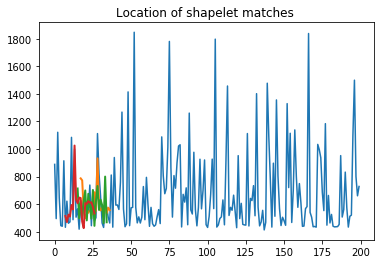

In [68]:
ts_id = 0
plt.figure()
n_shapelets = sum(shapelet_sizes.values())
plt.title("Location of shapelet matches "
          .format(n_shapelets))

plt.plot(X_train[ts_id].ravel())
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)

# Others Shapelet Discovery Methods

1- This implementation views the model as a layered graph, where each layer implements a forward, backword and parameters update methods (see below diagram). This abstraction simplifies thinking about the algorithm and implementing it.

https://github.com/mohaseeb/shaplets-python

In [41]:
from shapelets_lts.classification import LtsShapeletClassifier

In [42]:
shp_clf = LtsShapeletClassifier(
    K=3,
    R=1,
    L_min=10,
    epocs=100,
    lamda=0.01,
    eta=0.01,
    shapelet_initialization='segments_centroids',
    plot_loss=False
)

param K: number of shapelets
        
        
param R: scales of shapelet lengths
        
        
param L_min: minimum shapelet length

In [43]:
shp_clf.fit(X_train, y_train)

Network initialization ...
Using training data to initialize shaplets
Training ...
Using training data for validation


C:\Users\Gianmarco\anaconda3\envs\tfk\lib\site-packages\shapelets_lts\network\soft_min_layer.py:67: RuntimeWarning: invalid value encountered in double_scalars
  M = M_numerator / self.psi


epoch=1/100 (iteration=21) loss=nan validation accuracy=0.2857142857142857
epoch=2/100 (iteration=42) loss=nan validation accuracy=0.2857142857142857
epoch=3/100 (iteration=63) loss=nan validation accuracy=0.2857142857142857
epoch=4/100 (iteration=84) loss=nan validation accuracy=0.2857142857142857
epoch=5/100 (iteration=105) loss=nan validation accuracy=0.2857142857142857
epoch=6/100 (iteration=126) loss=nan validation accuracy=0.2857142857142857
epoch=7/100 (iteration=147) loss=nan validation accuracy=0.2857142857142857
epoch=8/100 (iteration=168) loss=nan validation accuracy=0.2857142857142857
epoch=9/100 (iteration=189) loss=nan validation accuracy=0.2857142857142857
epoch=10/100 (iteration=210) loss=nan validation accuracy=0.2857142857142857
epoch=11/100 (iteration=231) loss=nan validation accuracy=0.2857142857142857
epoch=12/100 (iteration=252) loss=nan validation accuracy=0.2857142857142857
epoch=13/100 (iteration=273) loss=nan validation accuracy=0.2857142857142857
epoch=14/100

LtsShapeletClassifier(K=3, L_min=10, R=1, alpha=-100, epocs=100, eta=0.01,
                      lamda=0.01, plot_loss=False,
                      shapelet_initialization='segments_centroids')

In [44]:
from sklearn.metrics import accuracy_score

In [45]:
y_pred = shp_clf.predict(X)

print("Correct classification rate:", accuracy_score(y, y_pred))

Correct classification rate: 0.3


In [22]:
# Non riesco ad ottenere una perdita e quindi non miglioro mai l'accuracy

2- The Shapelet Transform algorithm extracts the most discriminative shapelets from a data set of time series. A shapelet is defined as a subset of consecutive points from a time series. Two criteria are made available: mutual information and F-scores.

In [46]:
from pyts.transformation import ShapeletTransform

In [47]:
st = ShapeletTransform(n_shapelets=3, window_sizes=[8])
st.fit(X_train, y_train)

ShapeletTransform(criterion='mutual_info', n_jobs=None, n_shapelets=3,
                  random_state=None, remove_similar=True, sort=False, verbose=0,
                  window_sizes=[8], window_steps=None)

In [48]:
len(st.shapelets_)

3

In [49]:
st.shapelets_ #The array with the selected shapelets.

array([[ 448.25      ,  460.5       ,  444.        ,  570.5       ,
        1377.        , 1102.25      ,  920.33333333,  632.25      ],
       [ 457.33333333,  457.5       , 1129.        ,  477.        ,
         501.5       ,  457.        ,  511.        ,  450.5       ],
       [ 608.5       ,  795.        ,  462.        ,  597.        ,
         785.66666667,  630.        ,  703.        ,  582.        ]])

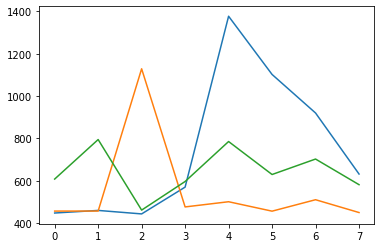

In [50]:
for s in st.shapelets_:
    plt.plot(s)

plt.show()

In [51]:
st.indices_ #The first column consists of the indices of the samples. The second column consists of the starting indices (included) of the shapelets. The third column consists of the ending indices (excluded) of the shapelets

array([[ 13,  79,  87],
       [ 14, 112, 120],
       [  4,  13,  21]], dtype=int64)

In [69]:
st.scores_ # The scores associated to the shapelets. The higher, the more discriminant. If criterion='mutual_info', mutual information scores are reported.

array([0.4495738 , 0.50788771, 0.56740207])